In [1]:
import pandas as pd
import numpy as np
import re
import string
import random

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def extract_columns(file_path):
    """
    Read a CSV file and extract only Score, Summary, and Text columns.
    """
    df = pd.read_csv(file_path)
    df = df[['Score', 'Summary', 'Text']].dropna()
    return df


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Apply normalization, stopword removal, and lemmatization (not stemming).
    """
    # Lowercase
    text = text.lower()
    # Remove URLs, HTML tags
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    # Remove emojis and special characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize and remove stopwords
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    cleaned = ' '.join(tokens)
    return cleaned


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


In [4]:
def filter_reviews(df, min_words=3, max_words=512):
    """
    Filters reviews with fewer than min_words or more than max_words.
    """
    df['review'] = (df['Summary'].fillna('') + ' ' + df['Text'].fillna('')).str.strip()
    df['review'] = df['review'].apply(clean_text)
    df['word_count'] = df['review'].apply(lambda x: len(x.split()))
    return df[(df['word_count'] >= min_words) & (df['word_count'] <= max_words)].copy()


In [5]:
def visualize_distributions(df):
    """
    Visualizes review counts and word count distributions per score.
    Also displays sample reviews per rating.
    """
    sns.countplot(x='Score', data=df)
    plt.title("Review Count per Rating")
    plt.show()

    sns.boxplot(x='Score', y='word_count', data=df)
    plt.title("Word Count Distribution by Rating")
    plt.show()

    # Display 3-10 sample reviews per rating
    for score in sorted(df['Score'].unique()):
        print(f'--- Sample Reviews for Rating {score} ---')
        samples = df[df['Score'] == score].sample(3, random_state=42)  # Change 3 to 10 for more
        for i, row in samples.iterrows():
            print(row['review'], '\n')


In [6]:
def create_balanced_dataset(df, samples_per_class=2000):
    """
    Under-samples each class to samples_per_class.
    """
    balanced_df = (
        df.groupby('Score')
          .apply(lambda x: x.sample(samples_per_class, random_state=42) if len(x) >= samples_per_class else x)
          .reset_index(drop=True)
    )
    return balanced_df


In [7]:
def stratified_split(df, test_size=0.2):
    """
    Performs a stratified train-test split, keeping class balance.
    """
    X = df['review'].values
    y = df['Score'].values
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test


In [8]:
def vectorize_text(X_train, X_test):
    """
    Vectorizes text using TF-IDF. Only fits on training data.
    """
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec, vectorizer


In [9]:
def main(file_path):
    # 1. Extract relevant columns
    df = extract_columns(file_path)
    # 2. Clean and filter
    df = filter_reviews(df)
    # 3. Visualization
    visualize_distributions(df)
    # 4. Balance dataset
    balanced_df = create_balanced_dataset(df, samples_per_class=2000)
    # 5. Shuffle
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    # 6. Stratified split
    X_train, X_test, y_train, y_test = stratified_split(balanced_df)
    # 7. Vectorization
    X_train_vec, X_test_vec, vectorizer = vectorize_text(X_train, X_test)
    # Now return ready for model training!
    return X_train_vec, X_test_vec, y_train, y_test


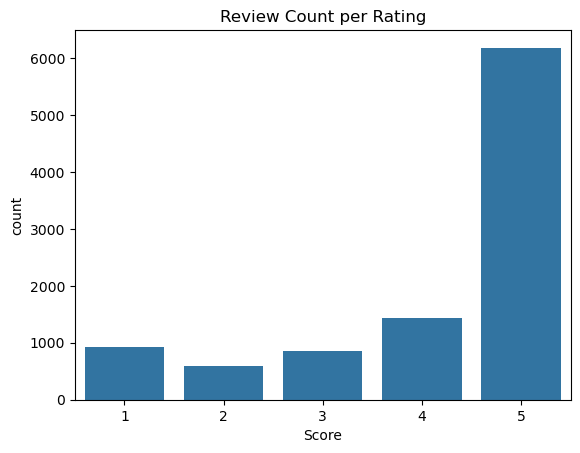

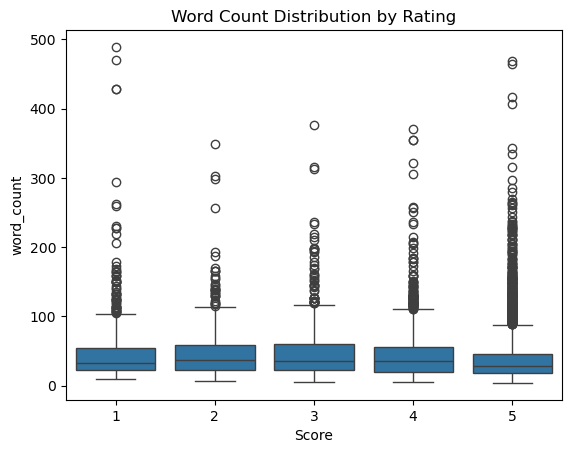

--- Sample Reviews for Rating 1 ---
flavored coffee nowhere description mention anything coffee flavored im still sure flavor type nut wrongly assumed jamaican coffee would similar blue mountain coffee jamaica known silly assume hate flavored coffee disappointed 2 box horrible coffee say flavored small box didnt notice opened hopefully pawn visitor buy regular bold coffeeflavored coffee 

worst frosting ever glad found reduced rack 99c taste bad way could frost cake stuck kniferan stringswhat mess thought gotten bad batchmy gd birthday cake look like crap would buy mess horrible 

sweet ive tried flavor switch carbonated juice drink enjoyed however particular flavor orange tangerine way sweet felt like drinking sort carbonated orange ade drink could barely get would probably purchase flavor switch definitely would purchase one 

--- Sample Reviews for Rating 2 ---
weak even small cup setting coffee brew weak like light roast wp chef reserve pod half full put pod scale 15 less coffee wg

C:\Users\HP\AppData\Local\Temp\ipykernel_29552\489797939.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(samples_per_class, random_state=42) if len(x) >= samples_per_class else x)


In [10]:
file_path = "D://Projects//automated-review-rating-system//data//New_Magu//Automated_Review.csv"
X_train, X_test, y_train, y_test = main(file_path)
